<h1>Chapter 9: Unsupervised Learning Techniques</h1>

Although most of the applications of ML today are based on supervised learning, the vast majority of the available data is unlabeled: we have the input features X but don't have the labels y. 

<h2>9.1 Clustering Algorithms: k-means and DBSCAN</h2>

<em>Clustering</em> is the task of identifying similar instances and assigning them to clusters, or groups of similar instances. Just like in classification , each instance gets assigned to a group. However, unlike classification, clustering is an unsupervised learning task. 

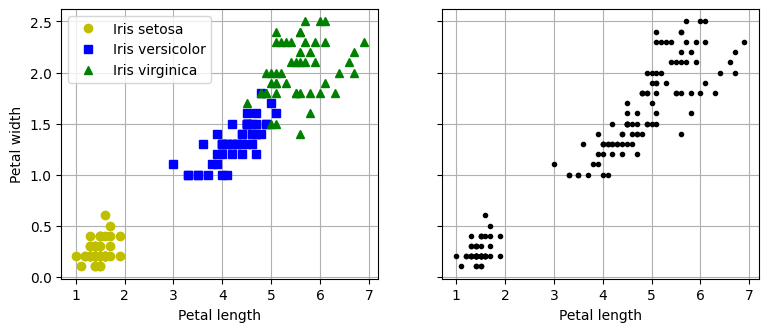

In [12]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length")
plt.tick_params(labelleft=False)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

In the above figure, on the left is the iris dataset, where each instance's species is represented with a different marker. It is a labeled dataset, for which classification algorithms such as logistic regression, SVMs, or random forest classifiers are well suited.

On the right is the same dataset, but without labels, so you can't use a simple classification algorithm anymore. This is where clustering algorithms step in: many of them can easily detect the lower-left cluster. 

<h3>9.1.1 k-means</h3>

Consider the unlabeled dataset represented below.

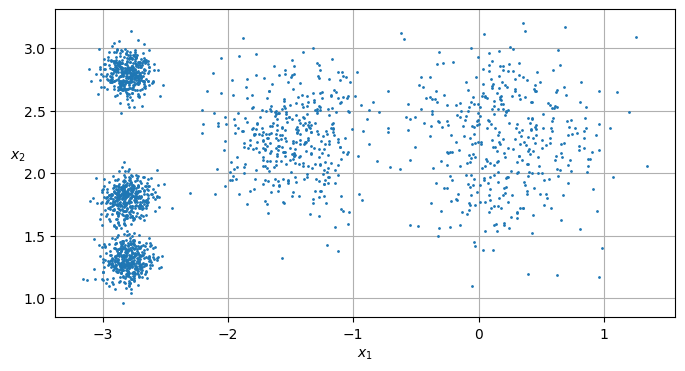

In [13]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
plt.show()

In this dataset, you can clearly see five blobs of instances. The k-means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in just a few iterations. 

Let's train a k-means clusterer on this dataset. It will try find each blob's center and assign each instance to the closest blob:

In [14]:
k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assign to one of the 5 clusters:

In [15]:
y_pred

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

And the following 5 centroids were estimated:

In [16]:
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

You can easily assign new instances to the cluster whose centroid is closest:

In [17]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3], dtype=int32)

If you plot the cluster's decision boundaries, you get a Voroni tesselation. In the below figure, each centroid is represented with an X:

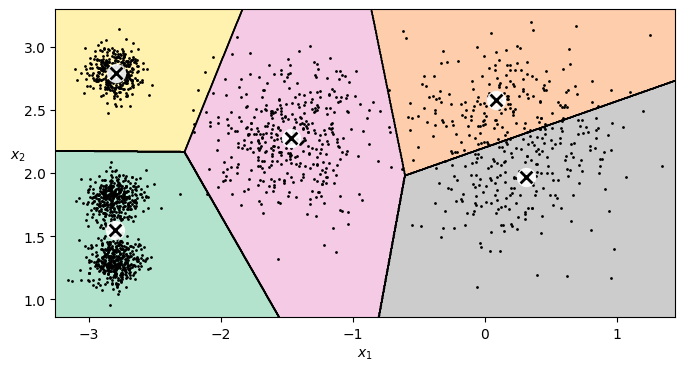

In [18]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Instead of assigning each instance to a single cluster, which is called <em>hard clustering</em>, it can be useful to give each instance a score per cluster, which is called <em>soft clustering</em>. The score cab be the distance between the instance and the centroid or a similar score (or affinity).

In the KMeans class, the transform() method measures the distance from each instance to every centroid:

In [19]:
kmeans.transform(X_new).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

If you have a high-dimensional dataset and you transform it this way, you end up with a k-dimensional dataset: this transformation can be a very efficient nonlinear dimensionality reduction technique. 

Alternatively, you can use these distances as features to train another model.

<h4>9.1.1.1 The k-means algorithm</h4>

So, how does this work? Suppose you were given the centroids. You could easily label all the instances in the dataset. Conversely, if you were given all the instance labels, you could easily locate each cluster's centroid by computing the mean of the instances in that cluster. But you are given neither the centroids or the labels. So, how do you proceed?

We start by placing the centroids randomly (e.g. by picking $k$ instances at random from the dataset and using their locations as centroids). Then label the instances, update the centroids, label the instances, update the centroids, and so on until the centroids stop moving. The algorithm is guaranteed to converge in a finite number of steps. This is because the mean squared distance between the instances and their closest centroids can only go down at each step, and since it can't be negative, it's guaranteed to converge. 

Although it's guaranteed to converge, it may not converge to the right solution (it may converge to a local optimum): whether it does or not depends on the centroid initialisation. 

<h4>9.1.1.2 Centroid initialisation methods</h4>

If you happen to know approximately where the centroids should be (e.g. you ran another clustering algorithm earlier), then you can set the init hyperparameter to a NumPy array containing the list of centroids, and set n_init to 1:

In [20]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

Another method is to run the algorithm multiple times with different initialisations and keep the best solution.

The best solution is found using a performance measure, called the <em>inertia</em>. This is the sum of the squared distances between the instances and their closest centroids. 

In [21]:
kmeans.inertia_

211.5985372581684

<h4>9.1.1.3 Accelerated k-means and mini-batch k-means</h4>

On some large datasets, the algorithm can be accelerated by avoiding many unnecessary calculations. This improvement was achieved by Charles Elkan in 2003, by exploiting the triangle inequality (i.e. that a straight line is always the shortest distance between two points). This doesn't always accelerate training, and can sometimes even slow it down. 

For Elkan's variant of K-Means, use algorithm="elkan".

Yet another important variant of the k-means algorithm was proposed in 2010 by David Sculley. Instead of using the full dataset at each iteration, the algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm
(typically by a factor of three to four) and makes it possible to cluster huge datasets that do not fit in memory. Scikit-Learn implements this algorithm in the MiniBatchKMeans class, which you can use just like the KMeans class:

In [22]:
from sklearn.cluster import MiniBatchKMeans
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

Although the mini-batches k-means algorithm is much faster than the regular k-means algorithm, its inertia is generally slightly worse. 

<h4>9.1.1.4 Finding the optimal number of clusters</h4>

In general, it isn't easy to know how to set $k$, and the result might be quite bad if we set it to the wrong value. You might think to just pick the model that has the lowest inertia, but the inertia actually isn't a good performance metric when trying to choose $k$ because it keeps getting lower as we increase $k$.

A way to choose the best value is to use the <em>silhouette score</em>, which is the mean <em>silhouette coefficient</em> over all the instances. An instance's silhouette coefficient is given by:
$$
\frac{b-a}{max(a,b)}
$$

Here, a is the mean distance to the other instances in the same cluster (i.e. the mean intra-cluster distance) and b is the mean nearest-cluster distance (i.e. the mean distance to the instances of the next closest cluster, defined as the one that minimises b, excluding the instance's own cluster).

To compute the silhouette score:

In [23]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

np.float64(0.655517642572828)

We can achieve an informative visualisation when we plot every instance's silhouette coefficient, sorted by clusters they're assigned to and by the value of the coefficient. This is called a <em>silhouette diagram</em>.

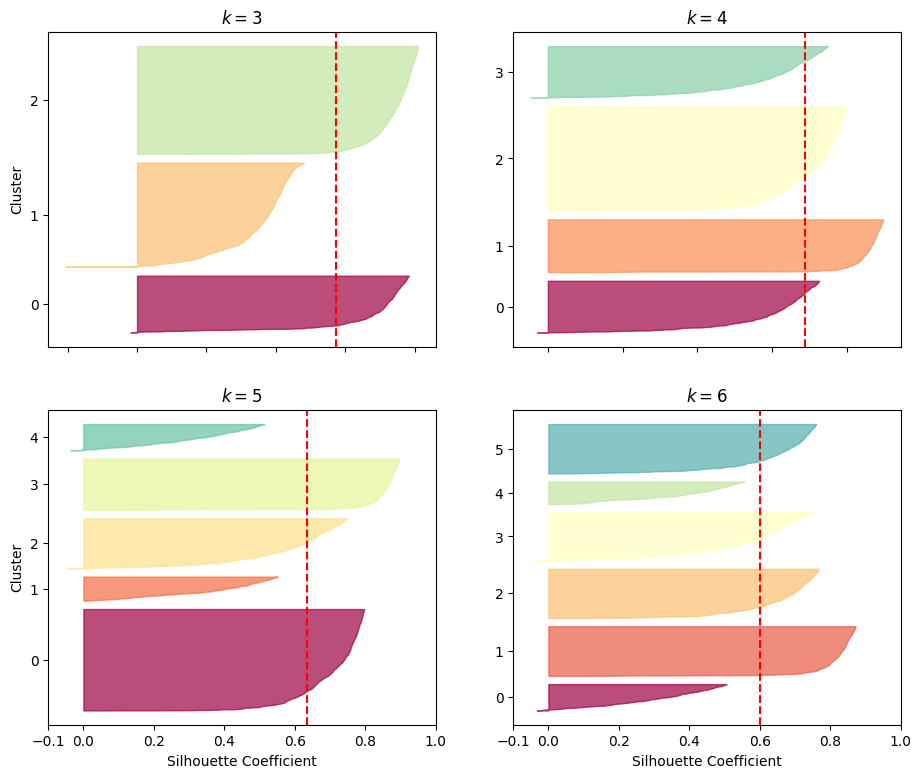

In [26]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

Each diagram contains one knife shape per cluster. The shape's height indicates the number of instances in the cluster, and its width represents the sorted silhouette coefficients of the instances in the cluster (the wider, the better). The vertical dashed lines represent the mean silhouette score for each number of clusters. 

<h4>9.1.1.5 Limits of k-means</h4>

Despite its many merits, most notably being fast and scalable, k-means is not perfect. As we saw, it is necessary to run the algorithm several times to avoid suboptimal solutions, plus you need to specify the number of clusters, which can be quite a hassle. Moreover, k-means does not behave very well when the clusters have varying sizes, different densities, or nonspherical shapes.

<h4>9.1.1.6 Using Clustering for Image Segmentation</h4>

<em>Image segmentation</em> is the task of partitioning an image into multiple segments. There are several variants:
<ul>
    <li>In <em>colour segmentation</em>, pixels with a similar colour get assigned to the same segment. </li>
    <li>In <em>semantic segmenetation</em>, all pixels that are part of the same object type get assigned to the same segment. For example, in a self-driving car's vision system, all pixels that are part of a pedestrian's image might be assigned to the "pedestrian" segment.</li>
    <li>In <em>instance segmentation</em>, all pixels that are part of the same individual object are assigned to the same segment. In this case, there would be a different segment for each pedestrian. </li>
</ul>

Semantic and instance segmenetation are achieved through complex architecture based on CNNs. Here, we'll look at colour segmentation, using k-means. 

We'll start by importing the ladybug dataset from Python's PIL library.

In [27]:
from pathlib import Path
import PIL
import urllib.request

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
filepath = IMAGES_PATH / filename

if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homl3_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

Here, the image is represented as a 3D array. The first dimension's size is the height, the second is the width, and the third is number of colour changes (RGB). In other words, for each pixel there is a 3D vector containing the intensities of RGB between 0 and 255.

The following code reshapes the array to get a long list of RGB colours, then it clusters them using k-means with eight clusters. It creates a segmented_img array containing the nearest cluster center for each pixel (i.e. the mean colour of each pixel's cluster), and reshapes this array to the original image shape. 

In [28]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, n_init=10, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

This outputs the image shown in the upper-right of the below figures.

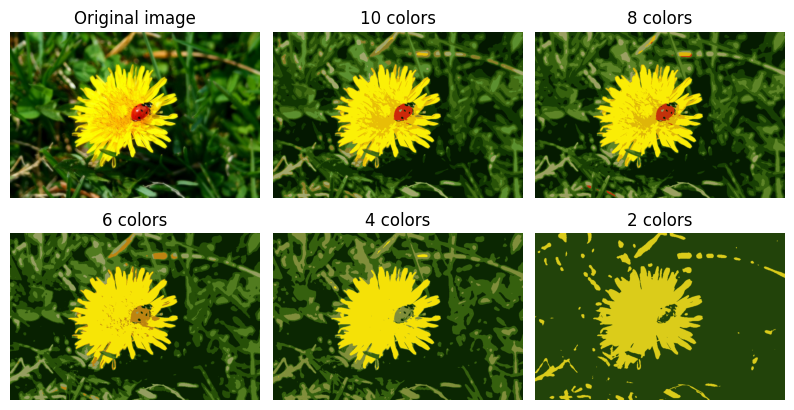

In [29]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

plt.show()

When you use fewer than eight clustesr, notice that the ladybug's flashy red colour fails to get a cluster on its own: it gets merged with colours from the environment. This is becase k-means prefers clusters of similar sizes. The ladybug is small - much smaller than the rest of the image - so even though its colour is flashy, k-means fails to dedicate a cluster to ti.

<h4>9.1.1.7 Using Clusterin for Semi-Supervised Learning</h4>

Another application of clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances. 

In [30]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

We will pretend we only have labels for 50 instances. To get a baseline performance, let’s train a logistic regression model on these 50 labeled instances:

In [31]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

We can then measure the accuracy of this model on the test set (note that the test set must be labeled):

In [32]:
log_reg.score(X_test, y_test)

0.7581863979848866

The model's accuracy is just 75%. That's not great. Let's see how we can do better. First, let's cluster the training set into 50 clusters. We'll call these images <em>representative images:</em>.

In [33]:
k = 50
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]

Plotting these images, and labelling them manually:

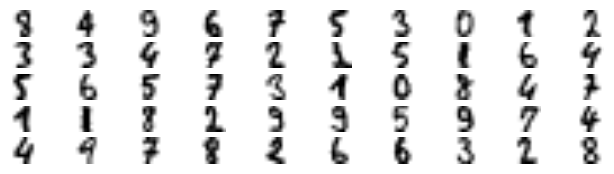

In [34]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

plt.show()

In [38]:
y_representative_digits = np.array([
    8, 4, 9, 6, 7, 5, 3, 0, 1, 2,
    3, 3, 4, 7, 2, 1, 5, 1, 6, 4,
    5, 6, 5, 7, 3, 1, 0, 8, 4, 7,
    1, 1, 8, 2, 9, 9, 5, 9, 7, 4,
    4, 9, 7, 8, 2, 6, 6, 3, 2, 8
])

Now we have a dataset with just 50 labeled instances, but instead of being random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [39]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8387909319899244

We have jumped from 75% accuracy to 83%, although we are still only training the model on 50 instances. Since it is often costly and painful to label instances, especially when it's to be done manually, it's a good idea to label representative instances rather than just random instances.

But, what if we propagated labels to all the other instances in the same cluster? This is called <em>label propagation</em>.

In [40]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)

for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

log_reg.score(X_test, y_test)

0.8589420654911839

Another accuracy bnboost. Let's see if we can do better by ignoring the 1% instances that are farthest from their cluster center, thus eliminating some outliers.

In [41]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8564231738035264

This has strangely led to an accuracy reduction. Let's see how our propagated labels are looking.

In [42]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

np.float64(0.9548148148148148)

<h3>9.1.2 DBSCAN</h3>

The <em>density-based spatial clustering of applications with noise</em> (DBSCAN) algorithm defines clusters as continuous regions of high density. This is how it works:
<ul>
    <li>For each instance, the algorithm counts how many instances are located within a small distance $\epsilon$ from it. This region is called the instance's $\epsilon$-neighborhood.</li>
    <li>IF an instance has at least min_samples instances in its $\epsilon$-neighborhood (including itself), then it's considered a core instance. </li>
    <li>All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may includ other core instances; therefore, a long sequence of neighboring core instancs forms a single cluster. </li>
    <li>Any instance that's not a core instance and doesn't have one in its neighborhood is considered an anomaly. </li>
</ul>

This algorithm works well if all the clusters are well separated by low-density regions.

In [43]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

Notice that some instances have a cluster index equal to -1. This means that tehy're considered as anomalies by the algorithm. 

The indices of the core instances are available in the core_samples_indices_instance variable, and the core instances themselves are available in the components_instance variable:

In [44]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [47]:
dbscan.components_[:5]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267]])

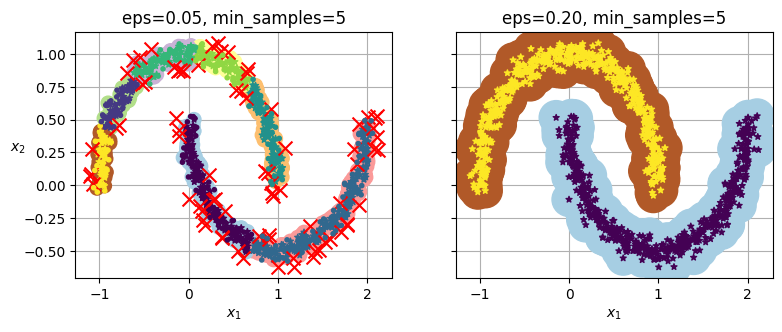

In [48]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

The aforementioned clustering is represented in the lefthand plot above. It identifies quite a lot of anomalies, plus seven different clusters. 

If we widen each instance's neighborhood by increasing epsilon to 0.2, we get the clustering on the right whhich looks perfect.

The DBSCAN class doesn't have a predict() method, although it has a fit_predict() method. In other words, it can't predcit which cluster a new instance belongs to. The decision was amde because different classification algorithms can be better for different tasks, so the authors decided to let the user choose which one to use.

Let's implement it in KNeighborsClassifier:

In [49]:
dbscan = dbscan2  

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [50]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

The decision boundary is represented below:

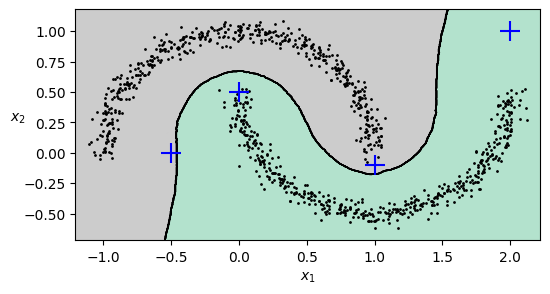

In [51]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

Notice that since there is no anomaly in the training set, the classifier always chooses a cluster, even when that cluster is far away. 

It's fairly straightforward to introduce a maximum distance, in which case the two instances that are far away from both clusters as classified as anomalies. To do this, use the kneighbors() method. Given a set of instances, it returns the distances and the indices of the k-nearest neighbors in the training set (two matrices, each with k columns):

In [52]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

<h2>9.2 Gaussian Mixtures</h2>

A <em>Gaussian mixture model</em> (GMM) is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. All the instances generated from a single Gaussian distribution form a cluster that typically looks like an ellipsoid. Each cluster can have a different ellipsoid shape, size, density, and orientation. When you observe an instance, you know it was generated from one of the Gaussian distributions, but you're not told which one, and you don't know what the parameteros of these distributions are. 

There are several GMM variants. In the simplest variant, implemented in the GaussianMixture class, you must know in advance the number $k$ of Gaussian distributions.

In [53]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components = 3, n_init = 10)
gm.fit(X)

gm.weights_

array([0.20919695, 0.58804739, 0.20275566])

In [54]:
gm.means_

array([[ 1.72961522, -0.07015012],
       [ 0.49201314,  0.25658167],
       [-0.74919734,  0.55462378]])

In [55]:
gm.covariances_

array([[[ 0.0616387 ,  0.06602368],
        [ 0.06602368,  0.08793079]],

       [[ 0.16432027, -0.09780172],
        [-0.09780172,  0.28771641]],

       [[ 0.05299485,  0.06166365],
        [ 0.06166365,  0.08966809]]])

In [56]:
gm.converged_

True

In [57]:
gm.n_iter_

16

Now that you have an estimation of the location, size, shape, orientation, and relative weight of each clsuter, the model can easily assign each instance to the most likely cluster (hard clustering) or estimate the probability that it belongs to a particular cluster (soft clustering).

Just use the predict() method for hard clusterin, or the predict_proba() method for soft clustering:

In [58]:
gm.predict(X)

array([1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 2, 0,
       2, 1, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1,
       1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2,
       0, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2,
       1, 1, 0, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 2, 1, 1, 0, 1,
       2, 1, 0, 1, 0, 1, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1,
       1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 2, 1, 0, 0, 1, 1, 2, 1, 1,
       2, 0, 0, 2, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1,
       2, 2, 1, 0, 0, 1, 1, 2, 2, 2, 0, 2, 1, 1, 1,

In [59]:
gm.predict_proba(X).round(3)

array([[0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       ...,
       [0.984, 0.016, 0.   ],
       [0.   , 0.   , 1.   ],
       [0.   , 1.   , 0.   ]])

A GMM is a generative model, meaning you can sample new instances from it (note that they are ordered by clsuter index):

In [60]:
X_new, y_new = gm.sample(6)

X_new

array([[ 1.90582868, -0.0803017 ],
       [ 1.656979  , -0.14064514],
       [ 0.6925683 ,  1.09346994],
       [ 0.93990747,  0.48158131],
       [ 0.34653203, -0.44326434],
       [-0.8752457 ,  0.28820838]])

In [61]:
y_new

array([0, 0, 1, 1, 1, 2])

<h3>9.2.1 Using Gaussian Mixtures for Anomaly Detection</h3>

Using a Gaussian mixture model for anomaly detection is quite simple: any instance located in a low-density region can be considered an anomaly. You must define what density threshold you want to use. Say it's equal to2%. You then set the density threshold to be the value that results in having 2% of the instances located in areas below the threshold density.

If you notice that you get too many false positives, you can lower the threshold. Conversely, if you have too many false negatives you can increase the threshold. This is the usual precision/recall trade-off. 

Here's how to identify the outliers using the fourth percentile lowest density as the threshold:


In [62]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

<h3>9.2.2 Selecting the Number of Clusters</h3>

With k-means, you can use the inertia or the silhouette score to select the appropriate number of clusters. But with Gaussian mixtures, it's not possible to use these metrics because tehy're not reliable when the clusters aren't spherical or have different sizes. Instead, you can try to find the model that minimises a <em>theoretical information criterion</em>, such as the <em>Bayesian information criterion</em> or the <em>Akaike information criterion</em>.

$$
BIC = log(m)p - 2log(\hat{L})
$$

$$
AIC = 2p - log(\hat{L})
$$

In these equations:
<ul>
    <li>m is the number of instances</li>
    <li>p is the number of paramaters learned by the model</li>
    <li>L is the maximum value of the likelihood function of the model</li>
</ul>

Both the BIC and AIC penalise models that have more parameters to learn (e.g. more clusters) and reward models that fit the data well. They often end up selecting the same model. When they differ, the model selected by BIC tends to be simpler (fewer parameters) than the one selected by AIC, but tends to not fit the data quite as well (especially true for larger datasets.)

In [66]:
gm.bic(X)

np.float64(2807.8798049204984)

In [67]:
gm.aic(X)

np.float64(2724.447965177802)

<h3>9.2.3 Bayesian Gaussian Mixture Models</h3>

Rather than manually searching for the optimal number of clusters, you can use the BayesianGaussianMixture class, which is capable of giving weights equal (or close) to zero to unnecessary clusters.

Set the number of clusters n_components to a value that you have good reason to believe is greater than the optimal number of clusters (this assumes some minimal knowledge of the problem at hand), and the algorithm will eliminate the unecessary clusters automatically. 

For example, let's set the number of clusters to 10 and see what happens:

In [68]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components = 10, n_init = 10, random_state = 42)
bgm.fit(X)
bgm.weights_.round(2)

C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


array([0.07, 0.15, 0.13, 0.12, 0.14, 0.16, 0.  , 0.11, 0.11, 0.  ])

The algorithm automatically detected that 8 clusters are needed.